## 0.0 Import Packages

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_criteo
from sklift.metrics import (
    qini_auc_score,
    uplift_at_k,
    uplift_auc_score,
    uplift_by_percentile,
)
from sklift.viz import (
    plot_qini_curve,
    plot_uplift_curve,
    plot_uplift_by_percentile,
)

pd.set_option("display.max_columns", 1200)

### 0.1 Utils

In [2]:
def get_metrics(y, uplift_effect, treatment):
    no_effect_share = round(100 * np.sum(uplift_effect == 0) / len(uplift_effect), 2)
    positive_effect_share = round(
        100 * np.sum(uplift_effect > 0) / len(uplift_effect), 2
    )
    negative_effect_share = round(
        100 * np.sum(uplift_effect < 0) / len(uplift_effect), 2
    )
    print(
        f"Model predicts positive effect in conversion after treatment for {positive_effect_share}% of cases."
    )
    print(
        f"Model predicts negative effect in conversion after treatment for {negative_effect_share}% of cases."
    )
    print(
        f"Model predicts no effect in conversion after treatment for {no_effect_share}% of cases."
    )

    uplift_at_10 = uplift_at_k(y, uplift_effect, treatment, strategy="overall", k=0.1)
    qini_coef = qini_auc_score(y, uplift_effect, treatment)
    uplift_auc = uplift_auc_score(y, uplift_effect, treatment)
    print(f"Uplift at 10% by overall: {uplift_at_10}")
    print(f"Qini coefficient - AUQC: {qini_coef}")
    print(f"Uplift AUC - AUUC: {uplift_auc}")

## 1.0 Data Exploration

In [3]:
dataset = fetch_criteo(target_col="conversion", treatment_col="treatment")
features, target, treatment = dataset.data, dataset.target, dataset.treatment

### 1.1 Features Description

In [5]:
features.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01


In [6]:
target.value_counts(normalize=True)

0    0.997083
1    0.002917
Name: conversion, dtype: Float64

In [9]:
treatment.value_counts(normalize=True)

1    0.85
0    0.15
Name: treatment, dtype: Float64

### 1.2 Train-Validation-Holdout Split

- Train: 80%
- Validation: 10%
- Holdout (Test): 10%

In [4]:
RANDOM_SEED = 42
VALIDATION_SIZE = 0.1
HOLDOUT_SIZE = 0.1

stratify_cols = pd.concat([treatment, target], axis=1)
(
    X_train_val,
    X_holdout,
    y_train_val,
    y_holdout,
    trmnt_train_val,
    trmnt_holdout,
) = train_test_split(
    features,
    target,
    treatment,
    test_size=HOLDOUT_SIZE,
    random_state=RANDOM_SEED,
    stratify=stratify_cols,
)

X_train, X_val, y_train, y_val, trmnt_train, trmnt_val = train_test_split(
    X_train_val,
    y_train_val,
    trmnt_train_val,
    test_size=VALIDATION_SIZE / (1 - HOLDOUT_SIZE),
    random_state=RANDOM_SEED,
    stratify=stratify_cols.loc[X_train_val.index],
)

In [5]:
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))
print(y_holdout.value_counts(normalize=True))

0    0.997083
1    0.002917
Name: conversion, dtype: Float64
0    0.997084
1    0.002916
Name: conversion, dtype: Float64
0    0.997084
1    0.002916
Name: conversion, dtype: Float64


In [6]:
print(trmnt_train.value_counts(normalize=True))
print(trmnt_val.value_counts(normalize=True))
print(trmnt_holdout.value_counts(normalize=True))

1    0.85
0    0.15
Name: treatment, dtype: Float64
1    0.85
0    0.15
Name: treatment, dtype: Float64
1    0.85
0    0.15
Name: treatment, dtype: Float64


### 1.3 Add treatment flag as a feature

In [7]:
X_train_cntrl = X_train[trmnt_train == 0]
X_train_trmnt = X_train[trmnt_train == 1]
X_val_cntrl = X_val[trmnt_val == 0]
X_val_trmnt = X_val[trmnt_val == 1]

## 2.0 Modelling

In [8]:
IS_UNBALANCE = True
N_ESTIMATORS = 1000

y_train = y_train.astype(int)
y_train_cntrl = y_train[trmnt_train == 0]
y_train_trmnt = y_train[trmnt_train == 1]
y_val = y_val.astype(int)
y_val_cntrl = y_val[trmnt_val == 0]
y_val_trmnt = y_val[trmnt_val == 1]
y_holdout = y_holdout.astype(int)

### 2.1 Optuna Hyperparameter Tuning - Control

In [35]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 5e-1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 3, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 1e2, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 1e2, log=True),
        "min_child_weight": trial.suggest_float(
            "min_child_weight", 1e-3, 1e2, log=True
        ),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 10, 100),
        "n_estimators": N_ESTIMATORS,
        "objective": "binary",
        "random_state": RANDOM_SEED,
        "boosting_type": "gbdt",
        "importance_type": "gain",
        "is_unbalance": IS_UNBALANCE,
        "verbose": -1,
    }

    model = LGBMClassifier(**params)
    model.fit(
        X_train_cntrl,
        y_train_cntrl,
        eval_set=[(X_val_cntrl, y_val_cntrl)],
    )

    auc = roc_auc_score(y_val_cntrl, model.predict_proba(X_val_cntrl)[:, 1])
    return auc


study_lgbm_cntrl = optuna.create_study(
    direction="maximize", study_name="lgbm_t_learner_cntrl"
)
study_lgbm_cntrl.optimize(
    objective, n_trials=5
)  # increase n_trials to get better results
best_params_cntrl = study_lgbm_cntrl.best_params
print(f"Best params: {best_params_cntrl}")
print(f"Best value: {study_lgbm_cntrl.best_value}")

[I 2025-03-02 15:33:40,594] A new study created in memory with name: lgbm_t_learner_cntrl


[LightGBM] [Warning] early_stopping_round is set=15, early_stopping_rounds=15 will be ignored. Current value: early_stopping_round=15
[1]	valid_0's binary_logloss: 0.0129725
[2]	valid_0's binary_logloss: 0.0125804
[3]	valid_0's binary_logloss: 0.0123576
[4]	valid_0's binary_logloss: 0.0122234
[5]	valid_0's binary_logloss: 0.0121617
[6]	valid_0's binary_logloss: 0.0121321
[7]	valid_0's binary_logloss: 0.0121295
[8]	valid_0's binary_logloss: 0.0121525
[9]	valid_0's binary_logloss: 0.0121902
[10]	valid_0's binary_logloss: 0.0122455
[11]	valid_0's binary_logloss: 0.0123049
[12]	valid_0's binary_logloss: 0.0123716
[13]	valid_0's binary_logloss: 0.0124476
[14]	valid_0's binary_logloss: 0.0125386
[15]	valid_0's binary_logloss: 0.0126292
[16]	valid_0's binary_logloss: 0.0127233
[17]	valid_0's binary_logloss: 0.012821
[18]	valid_0's binary_logloss: 0.012922
[19]	valid_0's binary_logloss: 0.0130296
[20]	valid_0's binary_logloss: 0.0131339


[I 2025-03-02 15:33:43,127] Trial 0 finished with value: 0.9501125314295731 and parameters: {'learning_rate': 0.0016722839473369327, 'num_leaves': 120, 'min_child_samples': 41, 'subsample': 0.5637044325862851, 'colsample_bytree': 0.6058104829573582, 'reg_alpha': 0.8325247065536435, 'reg_lambda': 0.08188483178746551, 'min_child_weight': 0.005795475100640057, 'early_stopping_rounds': 15}. Best is trial 0 with value: 0.9501125314295731.


[21]	valid_0's binary_logloss: 0.0132455
[22]	valid_0's binary_logloss: 0.0133646
[LightGBM] [Warning] early_stopping_round is set=92, early_stopping_rounds=92 will be ignored. Current value: early_stopping_round=92
[1]	valid_0's binary_logloss: 0.0117495
[2]	valid_0's binary_logloss: 0.0117815
[3]	valid_0's binary_logloss: 0.0119056
[4]	valid_0's binary_logloss: 0.0120909
[5]	valid_0's binary_logloss: 0.0123141
[6]	valid_0's binary_logloss: 0.0125715
[7]	valid_0's binary_logloss: 0.0128444
[8]	valid_0's binary_logloss: 0.0131353
[9]	valid_0's binary_logloss: 0.0134381
[10]	valid_0's binary_logloss: 0.013752
[11]	valid_0's binary_logloss: 0.0140715
[12]	valid_0's binary_logloss: 0.0143926
[13]	valid_0's binary_logloss: 0.0147252
[14]	valid_0's binary_logloss: 0.0150691
[15]	valid_0's binary_logloss: 0.015413
[16]	valid_0's binary_logloss: 0.0157567
[17]	valid_0's binary_logloss: 0.0161061
[18]	valid_0's binary_logloss: 0.0164602
[19]	valid_0's binary_logloss: 0.0168141
[20]	valid_0's b

[I 2025-03-02 15:33:50,525] Trial 1 finished with value: 0.9281359443314542 and parameters: {'learning_rate': 0.003973110102652555, 'num_leaves': 121, 'min_child_samples': 28, 'subsample': 0.786613549668951, 'colsample_bytree': 0.7501345339160888, 'reg_alpha': 0.30467939485920015, 'reg_lambda': 0.8313618807763506, 'min_child_weight': 0.20979344735668096, 'early_stopping_rounds': 92}. Best is trial 0 with value: 0.9501125314295731.


[93]	valid_0's binary_logloss: 0.0413777
[LightGBM] [Warning] early_stopping_round is set=52, early_stopping_rounds=52 will be ignored. Current value: early_stopping_round=52
[1]	valid_0's binary_logloss: 0.0998563
[2]	valid_0's binary_logloss: 0.102074
[3]	valid_0's binary_logloss: 0.104113
[4]	valid_0's binary_logloss: 0.106134
[5]	valid_0's binary_logloss: 0.108085
[6]	valid_0's binary_logloss: 0.109997
[7]	valid_0's binary_logloss: 0.111912
[8]	valid_0's binary_logloss: 0.113812
[9]	valid_0's binary_logloss: 0.115698
[10]	valid_0's binary_logloss: 0.117414
[11]	valid_0's binary_logloss: 0.119154
[12]	valid_0's binary_logloss: 0.120858
[13]	valid_0's binary_logloss: 0.122479
[14]	valid_0's binary_logloss: 0.124095
[15]	valid_0's binary_logloss: 0.125747
[16]	valid_0's binary_logloss: 0.127372
[17]	valid_0's binary_logloss: 0.128939
[18]	valid_0's binary_logloss: 0.130471
[19]	valid_0's binary_logloss: 0.131972
[20]	valid_0's binary_logloss: 0.133436
[21]	valid_0's binary_logloss: 0.

[I 2025-03-02 15:33:53,629] Trial 2 finished with value: 0.9473572890718576 and parameters: {'learning_rate': 0.016555473124650014, 'num_leaves': 15, 'min_child_samples': 48, 'subsample': 0.7842691658247927, 'colsample_bytree': 0.833183184689464, 'reg_alpha': 0.3124260416563459, 'reg_lambda': 0.4492041870746654, 'min_child_weight': 0.005724811313461872, 'early_stopping_rounds': 52}. Best is trial 0 with value: 0.9501125314295731.


[LightGBM] [Warning] early_stopping_round is set=61, early_stopping_rounds=61 will be ignored. Current value: early_stopping_round=61
[1]	valid_0's binary_logloss: 0.0131628
[2]	valid_0's binary_logloss: 0.0127673
[3]	valid_0's binary_logloss: 0.0125293
[4]	valid_0's binary_logloss: 0.0123715
[5]	valid_0's binary_logloss: 0.0122683
[6]	valid_0's binary_logloss: 0.0122004
[7]	valid_0's binary_logloss: 0.0121589
[8]	valid_0's binary_logloss: 0.0121361
[9]	valid_0's binary_logloss: 0.0121307
[10]	valid_0's binary_logloss: 0.0121396
[11]	valid_0's binary_logloss: 0.0121551
[12]	valid_0's binary_logloss: 0.0121792
[13]	valid_0's binary_logloss: 0.0122137
[14]	valid_0's binary_logloss: 0.012256
[15]	valid_0's binary_logloss: 0.0123011
[16]	valid_0's binary_logloss: 0.0123525
[17]	valid_0's binary_logloss: 0.012407
[18]	valid_0's binary_logloss: 0.0124664
[19]	valid_0's binary_logloss: 0.0125312
[20]	valid_0's binary_logloss: 0.0125957
[21]	valid_0's binary_logloss: 0.0126646
[22]	valid_0's b

[I 2025-03-02 15:34:01,342] Trial 3 finished with value: 0.9539183919469493 and parameters: {'learning_rate': 0.0013106140768738277, 'num_leaves': 176, 'min_child_samples': 15, 'subsample': 0.7771540339835343, 'colsample_bytree': 0.9620840557317458, 'reg_alpha': 0.03248658749998925, 'reg_lambda': 0.5468264122629478, 'min_child_weight': 19.489366164598753, 'early_stopping_rounds': 61}. Best is trial 3 with value: 0.9539183919469493.


[LightGBM] [Warning] early_stopping_round is set=11, early_stopping_rounds=11 will be ignored. Current value: early_stopping_round=11
[1]	valid_0's binary_logloss: 7.1866
[2]	valid_0's binary_logloss: 1.28584
[3]	valid_0's binary_logloss: 4.64766
[4]	valid_0's binary_logloss: 4.52753
[5]	valid_0's binary_logloss: 4.10007
[6]	valid_0's binary_logloss: 4.17374
[7]	valid_0's binary_logloss: 4.08529
[8]	valid_0's binary_logloss: 3.90179
[9]	valid_0's binary_logloss: 3.9797
[10]	valid_0's binary_logloss: 4.01273
[11]	valid_0's binary_logloss: 3.81049
[12]	valid_0's binary_logloss: 4.01312
[13]	valid_0's binary_logloss: 3.97319


[I 2025-03-02 15:34:03,473] Trial 4 finished with value: 0.09348060786154999 and parameters: {'learning_rate': 0.19532450889184547, 'num_leaves': 113, 'min_child_samples': 43, 'subsample': 0.9762669574039797, 'colsample_bytree': 0.6932629927296352, 'reg_alpha': 0.5184884799158824, 'reg_lambda': 0.03308115142392063, 'min_child_weight': 6.767588664401073, 'early_stopping_rounds': 11}. Best is trial 3 with value: 0.9539183919469493.


Best params: {'learning_rate': 0.0013106140768738277, 'num_leaves': 176, 'min_child_samples': 15, 'subsample': 0.7771540339835343, 'colsample_bytree': 0.9620840557317458, 'reg_alpha': 0.03248658749998925, 'reg_lambda': 0.5468264122629478, 'min_child_weight': 19.489366164598753, 'early_stopping_rounds': 61}
Best value: 0.9539183919469493


### 2.2 Optuna Hyperparameter Tuning - Treatment

In [37]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 5e-1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 3, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 1e2, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 1e2, log=True),
        "min_child_weight": trial.suggest_float(
            "min_child_weight", 1e-3, 1e2, log=True
        ),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 10, 100),
        "n_estimators": N_ESTIMATORS,
        "objective": "binary",
        "random_state": RANDOM_SEED,
        "boosting_type": "gbdt",
        "importance_type": "gain",
        "is_unbalance": IS_UNBALANCE,
        "verbose": -1,
    }

    model = LGBMClassifier(**params)
    model.fit(
        X_train_trmnt,
        y_train_trmnt,
        eval_set=[(X_val_trmnt, y_val_trmnt)],
    )

    auc = roc_auc_score(y_val_trmnt, model.predict_proba(X_val_trmnt)[:, 1])
    return auc


study_lgbm_trmnt = optuna.create_study(
    direction="maximize", study_name="lgbm_t_learner_trmnt"
)
study_lgbm_trmnt.optimize(
    objective, n_trials=5
)  # increase n_trials to get better results
best_params_trmnt = study_lgbm_trmnt.best_params
print(f"Best params: {best_params_trmnt}")
print(f"Best value: {study_lgbm_trmnt.best_value}")

[I 2025-03-02 15:34:03,512] A new study created in memory with name: lgbm_t_learner_trmnt


[LightGBM] [Warning] early_stopping_round is set=35, early_stopping_rounds=35 will be ignored. Current value: early_stopping_round=35
[1]	valid_0's binary_logloss: 0.0176007
[2]	valid_0's binary_logloss: 0.0179685
[3]	valid_0's binary_logloss: 0.0184669
[4]	valid_0's binary_logloss: 0.0190946
[5]	valid_0's binary_logloss: 0.0198069
[6]	valid_0's binary_logloss: 0.0205301
[7]	valid_0's binary_logloss: 0.0212724
[8]	valid_0's binary_logloss: 0.0220753
[9]	valid_0's binary_logloss: 0.0228884
[10]	valid_0's binary_logloss: 0.0237373
[11]	valid_0's binary_logloss: 0.0245792
[12]	valid_0's binary_logloss: 0.0254232
[13]	valid_0's binary_logloss: 0.0262582
[14]	valid_0's binary_logloss: 0.0271008
[15]	valid_0's binary_logloss: 0.0279515
[16]	valid_0's binary_logloss: 0.0288065
[17]	valid_0's binary_logloss: 0.0296497
[18]	valid_0's binary_logloss: 0.0305019
[19]	valid_0's binary_logloss: 0.0313713
[20]	valid_0's binary_logloss: 0.0322246
[21]	valid_0's binary_logloss: 0.0330856
[22]	valid_0's

[I 2025-03-02 15:34:29,376] Trial 0 finished with value: 0.9477319182434817 and parameters: {'learning_rate': 0.007053792670026498, 'num_leaves': 168, 'min_child_samples': 7, 'subsample': 0.7874209010235971, 'colsample_bytree': 0.6245975660011562, 'reg_alpha': 0.001177324562812208, 'reg_lambda': 51.79117089987425, 'min_child_weight': 8.014684881225557, 'early_stopping_rounds': 35}. Best is trial 0 with value: 0.9477319182434817.


[LightGBM] [Warning] early_stopping_round is set=15, early_stopping_rounds=15 will be ignored. Current value: early_stopping_round=15
[1]	valid_0's binary_logloss: 0.0181379
[2]	valid_0's binary_logloss: 0.0179499
[3]	valid_0's binary_logloss: 0.0180078
[4]	valid_0's binary_logloss: 0.0181997
[5]	valid_0's binary_logloss: 0.0184915
[6]	valid_0's binary_logloss: 0.0188282
[7]	valid_0's binary_logloss: 0.0192076
[8]	valid_0's binary_logloss: 0.019613
[9]	valid_0's binary_logloss: 0.0200617
[10]	valid_0's binary_logloss: 0.0205199
[11]	valid_0's binary_logloss: 0.020993
[12]	valid_0's binary_logloss: 0.0214811
[13]	valid_0's binary_logloss: 0.0219774
[14]	valid_0's binary_logloss: 0.0224895
[15]	valid_0's binary_logloss: 0.0230004
[16]	valid_0's binary_logloss: 0.023519
[17]	valid_0's binary_logloss: 0.0240432


[I 2025-03-02 15:34:47,415] Trial 1 finished with value: 0.9569313610924168 and parameters: {'learning_rate': 0.004893620881314802, 'num_leaves': 246, 'min_child_samples': 25, 'subsample': 0.5346825354289042, 'colsample_bytree': 0.6602206617446267, 'reg_alpha': 0.878705989939435, 'reg_lambda': 0.03771124225063231, 'min_child_weight': 50.33351084024374, 'early_stopping_rounds': 15}. Best is trial 1 with value: 0.9569313610924168.


[LightGBM] [Warning] early_stopping_round is set=96, early_stopping_rounds=96 will be ignored. Current value: early_stopping_round=96
[1]	valid_0's binary_logloss: 0.141719
[2]	valid_0's binary_logloss: 0.145157
[3]	valid_0's binary_logloss: 0.148409
[4]	valid_0's binary_logloss: 0.15131
[5]	valid_0's binary_logloss: 0.154092
[6]	valid_0's binary_logloss: 0.15686
[7]	valid_0's binary_logloss: 0.159605
[8]	valid_0's binary_logloss: 0.162564
[9]	valid_0's binary_logloss: 0.164902
[10]	valid_0's binary_logloss: 0.167112
[11]	valid_0's binary_logloss: 0.169243
[12]	valid_0's binary_logloss: 0.171491
[13]	valid_0's binary_logloss: 0.173708
[14]	valid_0's binary_logloss: 0.175826
[15]	valid_0's binary_logloss: 0.177811
[16]	valid_0's binary_logloss: 0.179996
[17]	valid_0's binary_logloss: 0.181982
[18]	valid_0's binary_logloss: 0.183924
[19]	valid_0's binary_logloss: 0.18571
[20]	valid_0's binary_logloss: 0.187593
[21]	valid_0's binary_logloss: 0.189344
[22]	valid_0's binary_logloss: 0.19106

[I 2025-03-02 15:35:18,286] Trial 2 finished with value: 0.9409729481350589 and parameters: {'learning_rate': 0.025902103978161135, 'num_leaves': 8, 'min_child_samples': 35, 'subsample': 0.5301802158798119, 'colsample_bytree': 0.8522150222741345, 'reg_alpha': 0.031185762660763117, 'reg_lambda': 1.3206441928076642, 'min_child_weight': 17.37299390455865, 'early_stopping_rounds': 96}. Best is trial 1 with value: 0.9569313610924168.


[LightGBM] [Warning] early_stopping_round is set=58, early_stopping_rounds=58 will be ignored. Current value: early_stopping_round=58
[1]	valid_0's binary_logloss: 6.75319
[2]	valid_0's binary_logloss: 1.12995
[3]	valid_0's binary_logloss: 2.82677
[4]	valid_0's binary_logloss: 4.89436
[5]	valid_0's binary_logloss: 4.67495
[6]	valid_0's binary_logloss: 4.64501
[7]	valid_0's binary_logloss: 4.62403
[8]	valid_0's binary_logloss: 4.75801
[9]	valid_0's binary_logloss: 4.64839
[10]	valid_0's binary_logloss: 3.77724
[11]	valid_0's binary_logloss: 3.60294
[12]	valid_0's binary_logloss: 4.06293
[13]	valid_0's binary_logloss: 3.7398
[14]	valid_0's binary_logloss: 3.86015
[15]	valid_0's binary_logloss: 3.83945
[16]	valid_0's binary_logloss: 3.43789
[17]	valid_0's binary_logloss: 5.02235
[18]	valid_0's binary_logloss: 4.50617
[19]	valid_0's binary_logloss: 4.38702
[20]	valid_0's binary_logloss: 3.30619
[21]	valid_0's binary_logloss: 4.66547
[22]	valid_0's binary_logloss: 4.39733
[23]	valid_0's bin

[I 2025-03-02 15:35:46,761] Trial 3 finished with value: 0.1360000647741514 and parameters: {'learning_rate': 0.2500799841127012, 'num_leaves': 75, 'min_child_samples': 30, 'subsample': 0.8653129884872853, 'colsample_bytree': 0.758769273860606, 'reg_alpha': 8.944299415146155, 'reg_lambda': 0.9212296422876032, 'min_child_weight': 0.00721682457395304, 'early_stopping_rounds': 58}. Best is trial 1 with value: 0.9569313610924168.


[LightGBM] [Warning] early_stopping_round is set=53, early_stopping_rounds=53 will be ignored. Current value: early_stopping_round=53
[1]	valid_0's binary_logloss: 0.0172755
[2]	valid_0's binary_logloss: 0.0181497
[3]	valid_0's binary_logloss: 0.019093
[4]	valid_0's binary_logloss: 0.0200865
[5]	valid_0's binary_logloss: 0.0211166
[6]	valid_0's binary_logloss: 0.02216
[7]	valid_0's binary_logloss: 0.0232177
[8]	valid_0's binary_logloss: 0.0242984
[9]	valid_0's binary_logloss: 0.0253748
[10]	valid_0's binary_logloss: 0.0264625
[11]	valid_0's binary_logloss: 0.0275574
[12]	valid_0's binary_logloss: 0.0286611
[13]	valid_0's binary_logloss: 0.0297541
[14]	valid_0's binary_logloss: 0.0308485
[15]	valid_0's binary_logloss: 0.0319376
[16]	valid_0's binary_logloss: 0.0330357
[17]	valid_0's binary_logloss: 0.0341333
[18]	valid_0's binary_logloss: 0.0352276
[19]	valid_0's binary_logloss: 0.0363256
[20]	valid_0's binary_logloss: 0.0374226
[21]	valid_0's binary_logloss: 0.038515
[22]	valid_0's bin

[I 2025-03-02 15:36:08,250] Trial 4 finished with value: 0.9518874234676115 and parameters: {'learning_rate': 0.0086856332365948, 'num_leaves': 16, 'min_child_samples': 36, 'subsample': 0.8649274721309537, 'colsample_bytree': 0.9461327357016123, 'reg_alpha': 6.560249161452028, 'reg_lambda': 0.001276834528939854, 'min_child_weight': 6.964501353412081, 'early_stopping_rounds': 53}. Best is trial 1 with value: 0.9569313610924168.


Best params: {'learning_rate': 0.004893620881314802, 'num_leaves': 246, 'min_child_samples': 25, 'subsample': 0.5346825354289042, 'colsample_bytree': 0.6602206617446267, 'reg_alpha': 0.878705989939435, 'reg_lambda': 0.03771124225063231, 'min_child_weight': 50.33351084024374, 'early_stopping_rounds': 15}
Best value: 0.9569313610924168


### 2.3 Model Training

In [41]:
model_trmnt = LGBMClassifier(
    **best_params_trmnt,
    importance_type="gain",
    n_estimators=N_ESTIMATORS,
    random_state=RANDOM_SEED,
    boosting_type="gbdt",
    objective="binary",
    is_unbalance=IS_UNBALANCE,
    verbose=-1,
)
model_trmnt.fit(
    X_train_trmnt,
    y_train_trmnt,
    eval_set=[(X_val_trmnt, y_val_trmnt)],
)

model_cntrl = LGBMClassifier(
    **best_params_cntrl,
    importance_type="gain",
    n_estimators=N_ESTIMATORS,
    random_state=RANDOM_SEED,
    boosting_type="gbdt",
    objective="binary",
    is_unbalance=IS_UNBALANCE,
    verbose=-1,
)
model_cntrl.fit(
    X_train_cntrl,
    y_train_cntrl,
    eval_set=[(X_val_cntrl, y_val_cntrl)],
)

[LightGBM] [Warning] early_stopping_round is set=15, early_stopping_rounds=15 will be ignored. Current value: early_stopping_round=15
[1]	valid_0's binary_logloss: 0.0181379
[2]	valid_0's binary_logloss: 0.0179499
[3]	valid_0's binary_logloss: 0.0180078
[4]	valid_0's binary_logloss: 0.0181997
[5]	valid_0's binary_logloss: 0.0184915
[6]	valid_0's binary_logloss: 0.0188282
[7]	valid_0's binary_logloss: 0.0192076
[8]	valid_0's binary_logloss: 0.019613
[9]	valid_0's binary_logloss: 0.0200617
[10]	valid_0's binary_logloss: 0.0205199
[11]	valid_0's binary_logloss: 0.020993
[12]	valid_0's binary_logloss: 0.0214811
[13]	valid_0's binary_logloss: 0.0219774
[14]	valid_0's binary_logloss: 0.0224895
[15]	valid_0's binary_logloss: 0.0230004
[16]	valid_0's binary_logloss: 0.023519
[17]	valid_0's binary_logloss: 0.0240432
[1]	valid_0's binary_logloss: 0.0131628
[2]	valid_0's binary_logloss: 0.0127673
[3]	valid_0's binary_logloss: 0.0125293
[4]	valid_0's binary_logloss: 0.0123715
[5]	valid_0's binary_

LGBMClassifier(colsample_bytree=0.9620840557317458, early_stopping_rounds=61,
               importance_type='gain', is_unbalance=True,
               learning_rate=0.0013106140768738277, min_child_samples=15,
               min_child_weight=19.489366164598753, n_estimators=1000,
               num_leaves=176, objective='binary', random_state=42,
               reg_alpha=0.03248658749998925, reg_lambda=0.5468264122629478,
               subsample=0.7771540339835343, verbose=-1)

## 3.0 Evaluation

### 3.1 Validation Set

In [42]:
uplift_effect_val = (
    model_trmnt.predict_proba(X_val)[:, 1] - model_cntrl.predict_proba(X_val)[:, 1]
)
get_metrics(y_val, uplift_effect_val, trmnt_val)

Model predicts positive effect in conversion after treatment for 92.37% of cases.
Model predicts negative effect in conversion after treatment for 7.63% of cases.
Model predicts no effect in conversion after treatment for 0.0% of cases.
Uplift at 10% by overall: 0.0074707770370467195
Qini coefficient - AUQC: 0.1478749828994641
Uplift AUC - AUUC: 0.004782467640827829


### 3.2 Holdout Set

In [43]:
uplift_effect_pred = (
    model_trmnt.predict_proba(X_holdout)[:, 1]
    - model_cntrl.predict_proba(X_holdout)[:, 1]
)
get_metrics(y_holdout, uplift_effect_pred, trmnt_holdout)

Model predicts positive effect in conversion after treatment for 92.37% of cases.
Model predicts negative effect in conversion after treatment for 7.63% of cases.
Model predicts no effect in conversion after treatment for 0.0% of cases.
Uplift at 10% by overall: 0.006895787304625173
Qini coefficient - AUQC: 0.13773685274527803
Uplift AUC - AUUC: 0.004457690151152151


In [48]:
uplift_by_percentile_pddf = uplift_by_percentile(
    y_holdout, uplift_effect_pred, trmnt_holdout, strategy="overall", bins=10
)
uplift_by_percentile_pddf.reset_index().head(10)

,percentile,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
0,0-10,120315,19481,0.022449,0.015554,0.006896
1,10-20,119144,20652,0.003240,0.001840,0.001400
2,20-30,118431,21365,0.000515,0.000374,0.000141
3,30-40,118731,21065,0.000278,0.000047,0.000230
4,40-50,118568,21228,0.000059,0.000000,0.000059
5,50-60,118615,21181,0.000185,0.000142,0.000044
6,60-70,118544,21252,0.000363,0.000423,-0.000061
7,70-80,118523,21273,0.000489,0.000329,0.000160
8,80-90,118643,21153,0.000708,0.000378,0.000330
9,90-100,118752,21044,0.002324,0.001378,0.000946


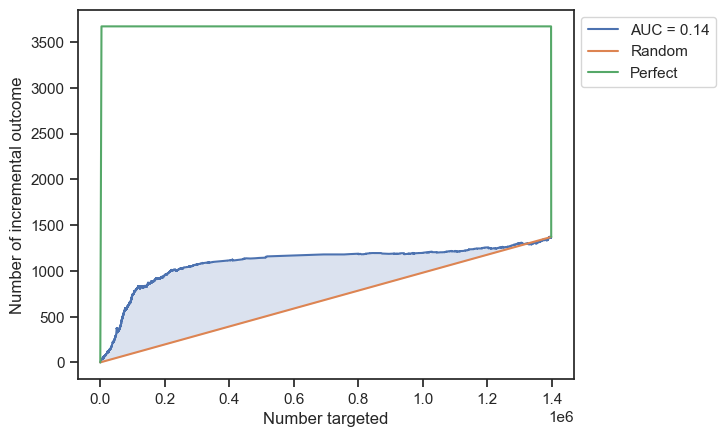

In [51]:
plot_qini_curve(y_holdout, uplift_effect_pred, trmnt_holdout, perfect=True)

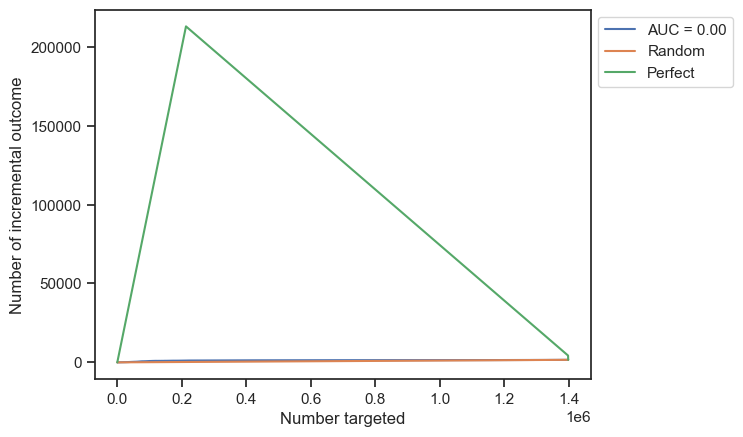

In [52]:
plot_uplift_curve(y_holdout, uplift_effect_pred, trmnt_holdout, perfect=True)

/Users/luna/anaconda3/envs/yh_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



<AxesSubplot: title={'center': 'Uplift by percentile\nweighted average uplift = 0.0012'}, xlabel='Percentile', ylabel='Uplift = treatment response rate - control response rate'>

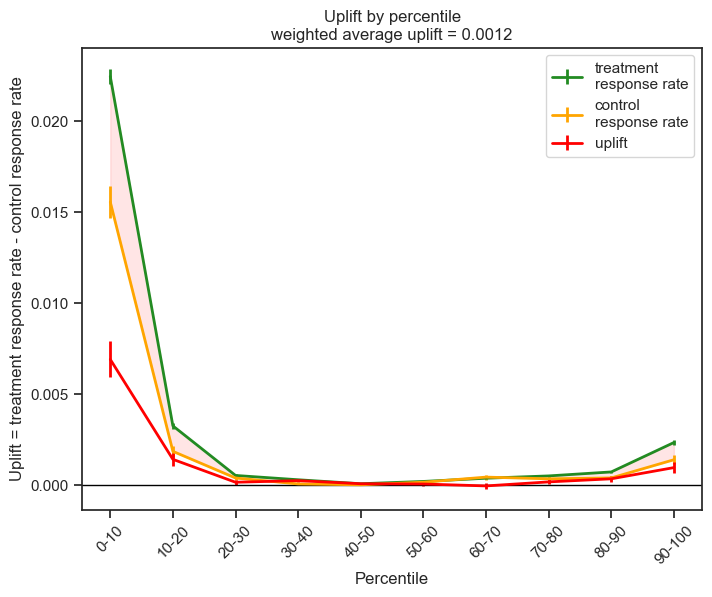

In [53]:
plot_uplift_by_percentile(
    y_holdout, uplift_effect_pred, trmnt_holdout, strategy="overall", bins=10
)

In [55]:
score_if_treatment = model_trmnt.predict_proba(X_holdout)[:, 1]
score_if_control = model_cntrl.predict_proba(X_holdout)[:, 1]
uplift_effect_pred = score_if_treatment - score_if_control

final_result = pd.DataFrame(
    {
        "score_if_treatment": score_if_treatment,
        "score_if_control": score_if_control,
        "uplift_effect_pred": uplift_effect_pred,
        "treatment": trmnt_holdout,
        "conversion": y_holdout,
    }
)
final_result["group"] = final_result["treatment"].apply(
    lambda x: "treatment" if x == 1 else "control"
)
final_result["uplift_score_vntl"] = 20 - pd.qcut(
    final_result["uplift_effect_pred"].rank(method="first"), 20, labels=False
)

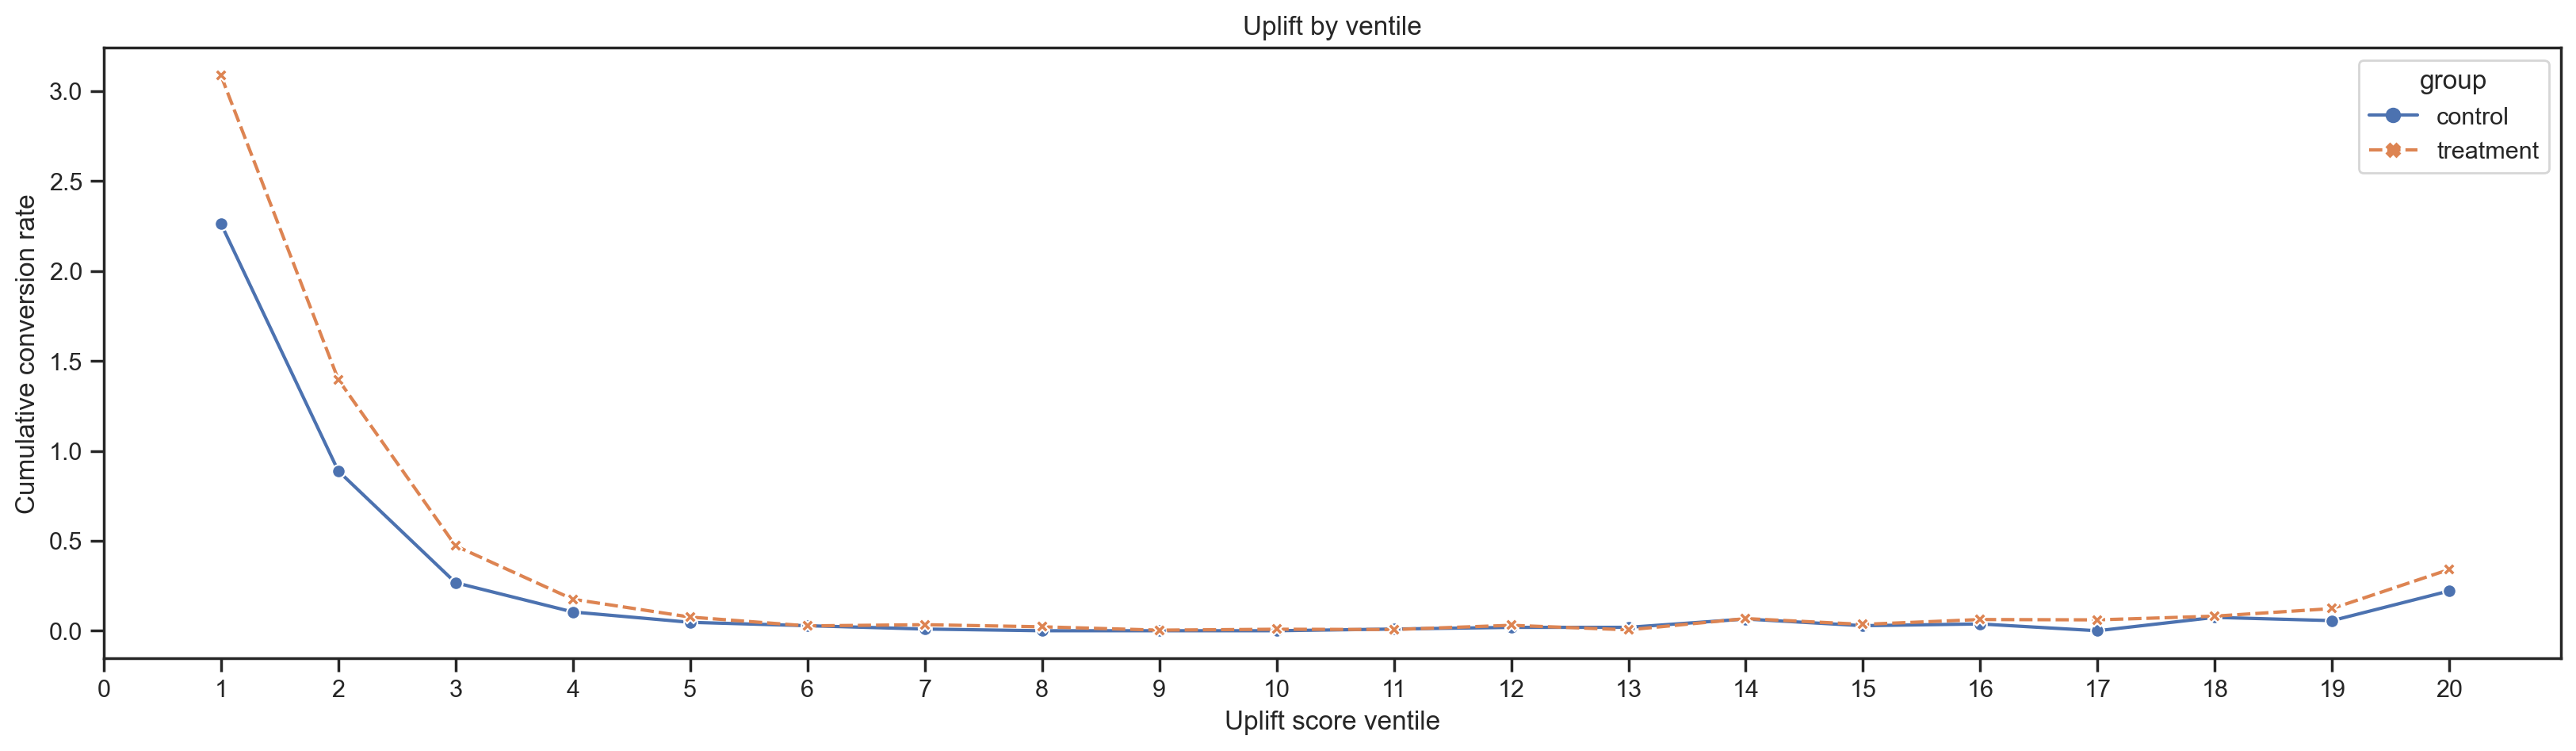

In [57]:
pctl = (
    final_result.groupby(["uplift_score_vntl", "group"])
    .agg(
        base_size=("score_if_control", "count"),
        conversion_rate=("conversion", lambda x: x.mean() * 100),
        takeup_count=("conversion", "sum"),
    )
    .reset_index()
)
pctl["cumulative_takeup_count"] = pctl.groupby("group")["takeup_count"].cumsum()
pctl["cumulative_base_size"] = pctl.groupby("group")["base_size"].cumsum()
pctl["cumulative_conversion_rate"] = (
    pctl["cumulative_takeup_count"] / pctl["cumulative_base_size"] * 100
)

sns.set(style="ticks", font_scale=1)
plt.figure(figsize=(20, 5), dpi=200)
sns.lineplot(
    x=pctl["uplift_score_vntl"],
    y=pctl["conversion_rate"],
    hue=pctl["group"],
    style=pctl["group"],
    markers=True,
)
plt.title("Uplift by ventile")
plt.xlabel("Uplift score ventile")
plt.ylabel("Cumulative conversion rate")
plt.xticks(np.arange(0, 21, 1))
plt.show()

## 4.0 Explainability

### 4.1 Feature Importance

In [58]:
importances = model_trmnt.feature_importances_
features = model_trmnt.feature_name_

importances_pddf = pd.DataFrame({"feature": features, "importance": importances})
importances_pddf = importances_pddf.sort_values("importance", ascending=False)
importances_pddf.head(10)

,feature,importance
8,f8,9.401305e+08
2,f2,5.438295e+07
11,f11,5.426192e+07
3,f3,3.608632e+07
6,f6,2.198478e+07
9,f9,6.604976e+06
10,f10,5.711116e+06
0,f0,3.494375e+06
7,f7,8.589989e+05
4,f4,7.513519e+05


In [59]:
importances = model_cntrl.feature_importances_
features = model_cntrl.feature_name_

importances_pddf = pd.DataFrame({"feature": features, "importance": importances})
importances_pddf = importances_pddf.sort_values("importance", ascending=False)
importances_pddf.head(10)

,feature,importance
8,f8,4.720727e+08
2,f2,4.044149e+07
10,f10,4.002144e+07
9,f9,3.264431e+07
0,f0,1.158450e+07
6,f6,1.010983e+07
3,f3,2.703610e+06
4,f4,1.773334e+06
7,f7,1.110904e+06
11,f11,2.649640e+05


### 4.2 SHAP Values

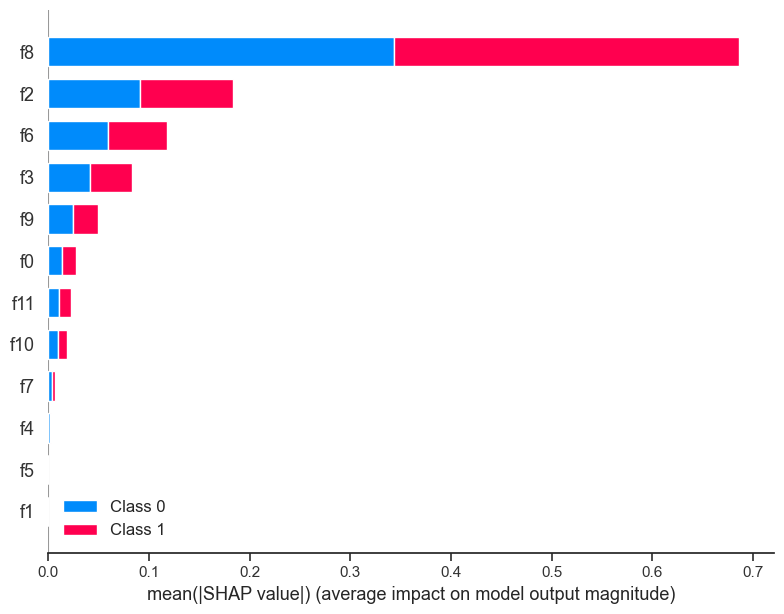

In [62]:
explainer = shap.TreeExplainer(model_trmnt, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_train_trmnt, y_train_trmnt)

shap.summary_plot(shap_values, X_train_trmnt)

/Users/luna/anaconda3/envs/yh_py38/lib/python3.8/site-packages/shap/explainers/_tree.py:429: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



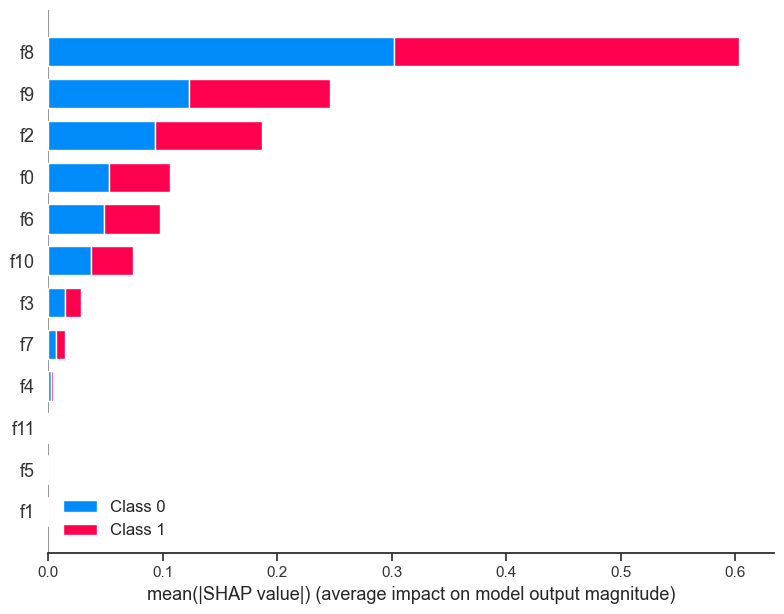

In [61]:
explainer = shap.TreeExplainer(model_cntrl, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_train_cntrl, y_train_cntrl)

shap.summary_plot(shap_values, X_train_cntrl)